# Рекуррентные нейронных сетей

In [23]:
import tensorflow as tf
from tensorflow import keras

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False


In [2]:
df = pd.read_excel("Revised_Data_Turbine.xlsx")
df

,Index,Hour_Time,Gas_fuel_fired_hours,Liquid fuel fired hours,Turbine hours,Start count,Compressor inlet air temp. (T1),Compressor T5 average,Turbine air inlet filter DP,Compressor outlet air pressure (PCD),...,Generator excitation current,Generator L1 winding temperature,Generator L2 winding temperature,Generator L3 winding temperature,Instrument Air Pressure,Enclosure Main Filter DP,Turbine Air Inlet Filter DP2,Turbine Air Inlet Pre Filter DP,Turbine Air Inlet PrePre Filter DP,Gas Fuel Control Temperature
0,0,H7,8613,3018,11678.0,925,26.1,280.0,0.99,8.4,...,2.4,49.0,50,50.0,6.14,0.8,1,0.92,0.26,38
1,1,H8,8614,3018,11679.0,925,25.7,282.0,0.98,8.4,...,2.4,48.0,49,49.0,6.19,0.8,0.97,0.91,0.25,37
2,2,H9,8615,3018,11680.0,925,25.5,279.0,0.97,8.4,...,2.4,47.0,48,48.0,6.21,0.79,0.98,0.91,0.26,35
3,3,H10,8616,3018,11681.0,925,25.4,277.0,0.99,8.4,...,2.4,47.0,48,48.0,6.22,0.79,1,0.93,0.27,35
4,4,H11,8617,3018,11683.0,925,25.4,277.0,0.99,8.4,...,2.4,47.0,48,48.0,6.22,0.79,1,0.93,0.27,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2979,2979,H2,11400,3374,14818.0,24.1,1250.0,545.0,1.08,9.8,...,3.9,67.0,68,68.0,6.58,0.46,1.08,1.13,0.8,31
2980,2980,H3,11401,3374,14819.0,23.9,1250.0,520.0,1.05,9.7,...,3.7,65.0,66,66.0,6.63,0.47,1.06,1.13,0.64,31
2981,2981,H4,11402,3374,14820.0,22.8,1250.0,582.0,1.06,9.8,...,3.9,65.0,66,66.0,6.59,0.47,1.06,1.13,0.77,30
2982,2982,H5,11403,3374,14821.0,21.8,1250.0,385.0,1.05,9,...,3,62.0,63,63.0,6.59,0.47,1.06,1.13,0.79,30


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000020E670FB5C0>],
      dtype=object)

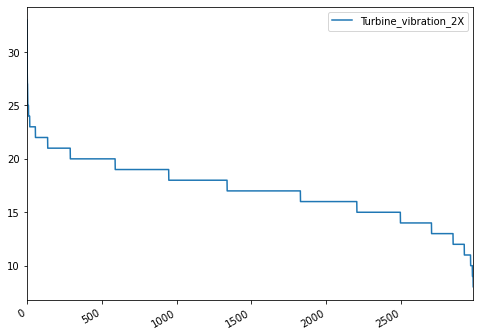

In [3]:
n = 0
k = None
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False
uni_data = df.sort_values(by=['Turbine_vibration_2X'], ascending=False)[['Turbine_vibration_2X']][n:k]
uni_data.index = list(df.index.values[n:k])
uni_data.head()
uni_data.plot(subplots=True)

In [4]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [5]:
TRAIN_SPLIT = 2000
tf.random.set_seed(1)

In [6]:
uni_data = df['Turbine_vibration_2X']
uni_data.index = df.index
uni_data.head()

0    15
1    14
2    15
3    15
4    15
Name: Turbine_vibration_2X, dtype: int64

In [7]:
uni_data = uni_data.values

In [8]:
uni_data = tf.keras.utils.normalize(uni_data)[0]
uni_data

array([0.01580318, 0.01474964, 0.01580318, ..., 0.02107091, 0.02001736,
       0.02001736])

In [9]:
def create_time_steps(length):
  return list(range(-length, 0))
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

In [10]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

# LSTM-модель для прогнозирование

In [11]:
features_considered = ['Turbine_vibration_2X',
       'Turbine_vibration_2Y']

In [12]:
features = df[features_considered]
#features.index = df['Date Time']
features.head()

,Turbine_vibration_2X,Turbine_vibration_2Y
0,15,9
1,14,9
2,15,10
3,15,10
4,15,10


In [13]:
features.max()

Turbine_vibration_2X    33
Turbine_vibration_2Y    33
dtype: int64

In [14]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

In [15]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

# Multidemensial

In [16]:
past_history = 100
future_target = 3
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 0], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 0],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [17]:
x_train_single.shape

(1900, 100, 2)

In [18]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (100, 2)


In [19]:
BATCH_SIZE = 64
BUFFER_SIZE = 100
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [20]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(64, input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(128))
single_step_model.add(tf.keras.layers.Dense(1, activation='linear'))

single_step_model.compile(optimizer='adam', loss='mse')

In [21]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(64, 1)


100

In [22]:
EVALUATION_INTERVAL = 200
single_step_history = single_step_model.fit(train_data_single, epochs=100,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=200)

Epoch 1/100
200/200 [==============================] - 16s 78ms/step - loss: 0.5923 - val_loss: 0.4675
Epoch 2/100
200/200 [==============================] - 16s 81ms/step - loss: 0.4976 - val_loss: 0.4747
Epoch 3/100
200/200 [==============================] - 17s 85ms/step - loss: 0.4664 - val_loss: 0.4913
Epoch 4/100
200/200 [==============================] - 17s 85ms/step - loss: 0.4199 - val_loss: 0.5186
Epoch 5/100
200/200 [==============================] - 17s 85ms/step - loss: 0.3788 - val_loss: 0.5444
Epoch 6/100
200/200 [==============================] - 17s 85ms/step - loss: 0.3588 - val_loss: 0.7037
Epoch 7/100
200/200 [==============================] - 17s 87ms/step - loss: 0.3244 - val_loss: 0.5623
Epoch 8/100
200/200 [==============================] - 17s 85ms/step - loss: 0.2807 - val_loss: 0.6140
Epoch 9/100
200/200 [==============================] - 17s 85ms/step - loss: 0.2778 - val_loss: 0.6214
Epoch 10/100
200/200 [==============================] - 17s 85ms/step - l

Epoch 80/100
200/200 [==============================] - 18s 91ms/step - loss: 0.0224 - val_loss: 0.6882
Epoch 81/100
200/200 [==============================] - 17s 86ms/step - loss: 0.0145 - val_loss: 0.7201
Epoch 82/100
200/200 [==============================] - 17s 86ms/step - loss: 0.0188 - val_loss: 0.6706
Epoch 83/100
200/200 [==============================] - 17s 86ms/step - loss: 0.0205 - val_loss: 0.7144
Epoch 84/100
200/200 [==============================] - 17s 86ms/step - loss: 0.0257 - val_loss: 0.7087
Epoch 85/100
200/200 [==============================] - 17s 86ms/step - loss: 0.0154 - val_loss: 0.6934
Epoch 86/100
200/200 [==============================] - 17s 86ms/step - loss: 0.0186 - val_loss: 0.6873
Epoch 87/100
200/200 [==============================] - 17s 85ms/step - loss: 0.0237 - val_loss: 0.6973
Epoch 88/100
200/200 [==============================] - 17s 86ms/step - loss: 0.0221 - val_loss: 0.6671
Epoch 89/100
200/200 [==============================] - 17s 86ms

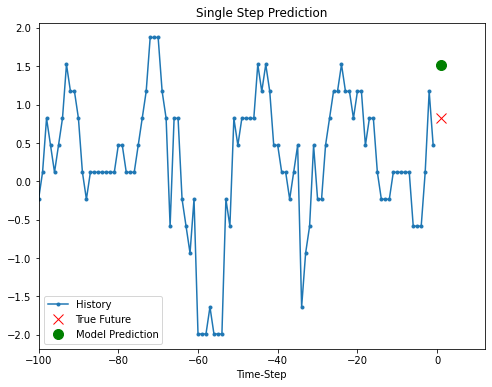

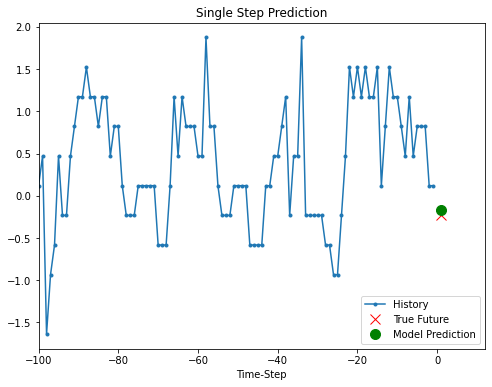

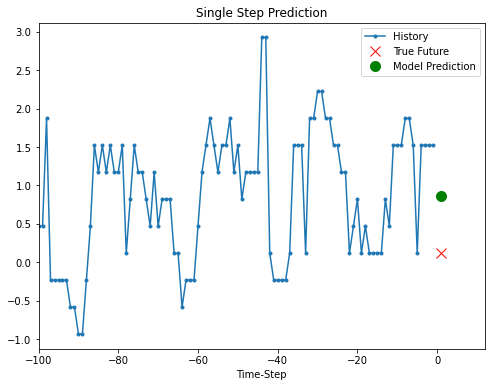

In [23]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 0].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 1,
                   'Single Step Prediction')
  plot.show()

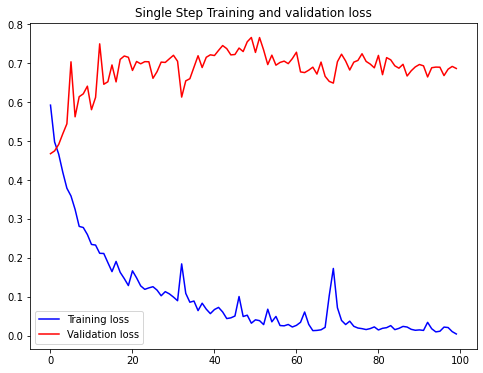

In [24]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

# Interval

In [16]:
past_history = 100
future_target = 6
STEP = 1
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 None, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [17]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (100, 2)

 Target temperature to predict : (6,)


In [18]:
BATCH_SIZE = 64
BUFFER_SIZE = 100

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [69]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history[80:]))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[80:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo', 
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

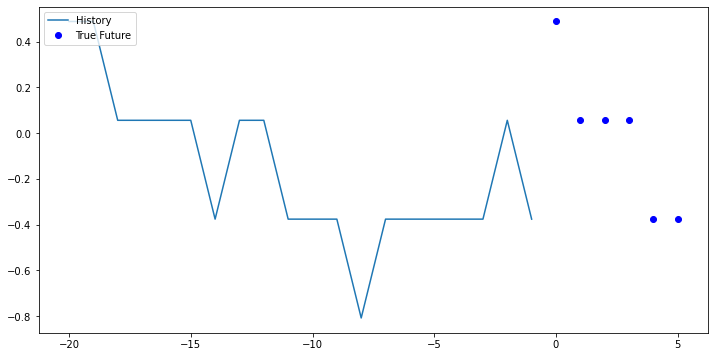

In [70]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [43]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(64, return_sequences=True, input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(128, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(6))

multi_step_model.compile(optimizer='adam', loss='mse')

In [44]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(64, 6)


In [45]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=50,
                                          steps_per_epoch=200,
                                          validation_data=val_data_multi,
                                          validation_steps=200)

Epoch 1/50
200/200 [==============================] - 29s 143ms/step - loss: 0.9006 - val_loss: 0.7692
Epoch 2/50
200/200 [==============================] - 31s 153ms/step - loss: 0.7847 - val_loss: 0.6744
Epoch 3/50
200/200 [==============================] - 32s 158ms/step - loss: 0.7236 - val_loss: 0.6259
Epoch 4/50
200/200 [==============================] - 30s 148ms/step - loss: 0.6561 - val_loss: 0.6155
Epoch 5/50
200/200 [==============================] - 29s 147ms/step - loss: 0.6545 - val_loss: 0.5792
Epoch 6/50
200/200 [==============================] - 30s 150ms/step - loss: 0.6401 - val_loss: 0.5798
Epoch 7/50
200/200 [==============================] - 31s 155ms/step - loss: 0.5956 - val_loss: 0.5502
Epoch 8/50
200/200 [==============================] - 32s 162ms/step - loss: 0.5999 - val_loss: 0.5438
Epoch 9/50
200/200 [==============================] - 31s 155ms/step - loss: 0.5636 - val_loss: 0.5427
Epoch 10/50
200/200 [==============================] - 30s 150ms/step - l

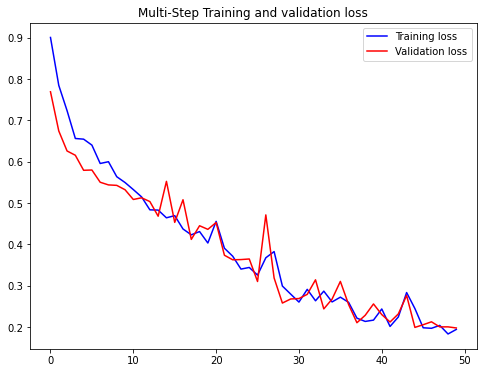

In [48]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

In [26]:
multi_step_model = keras.models.load_model("interval")

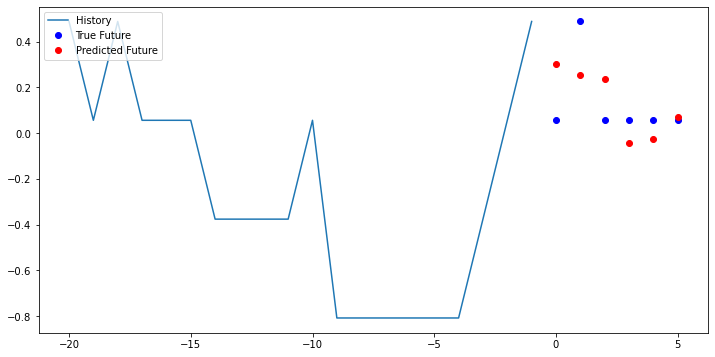

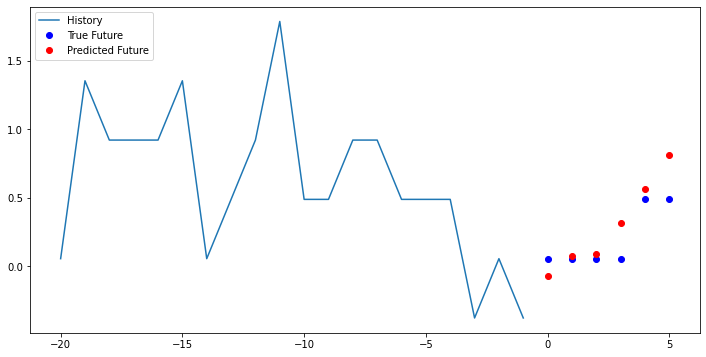

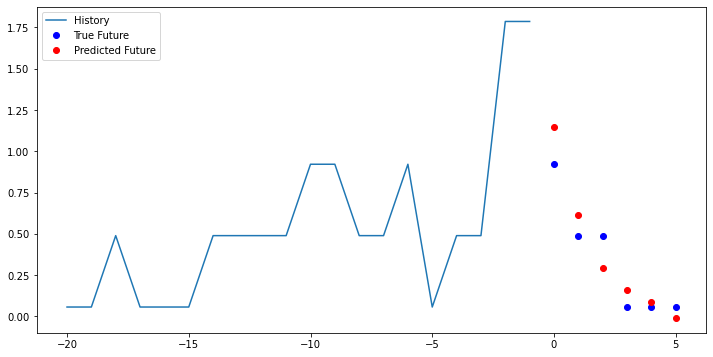

In [71]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

# TESTING

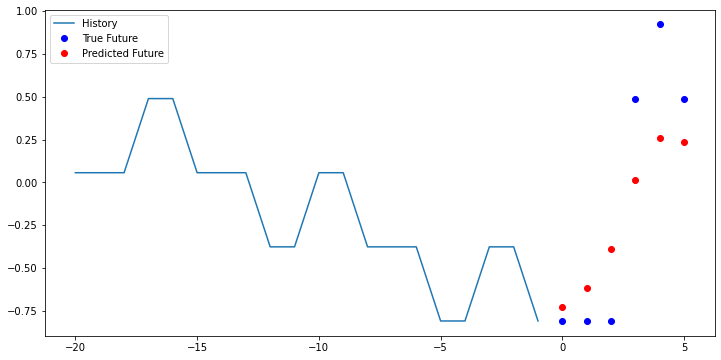

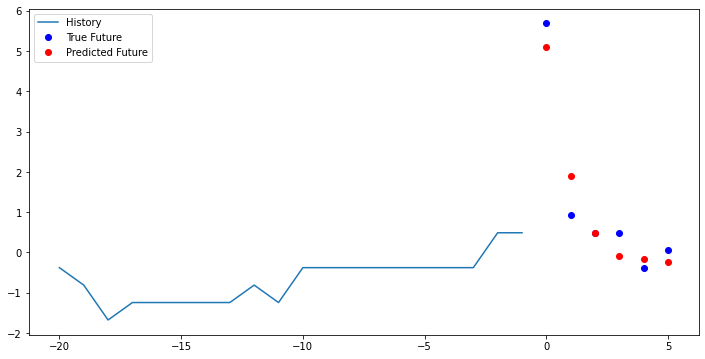

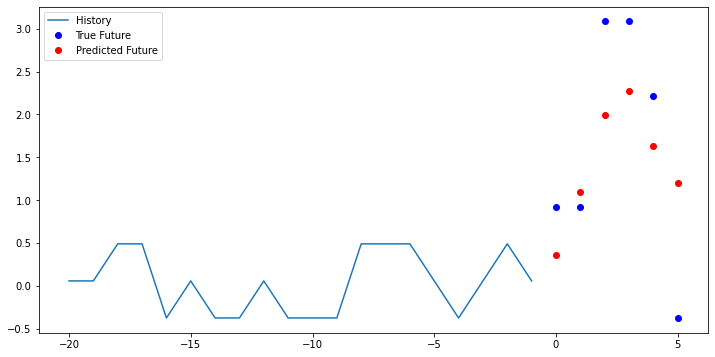

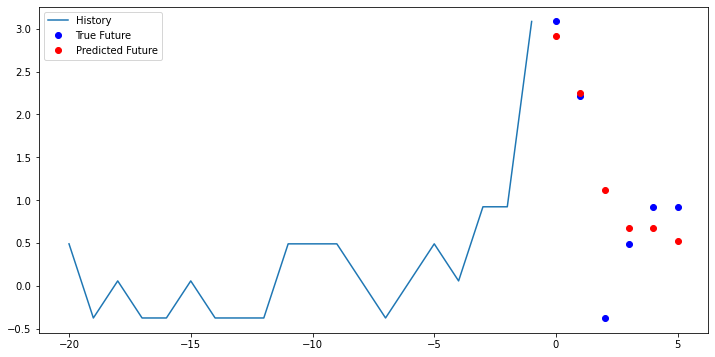

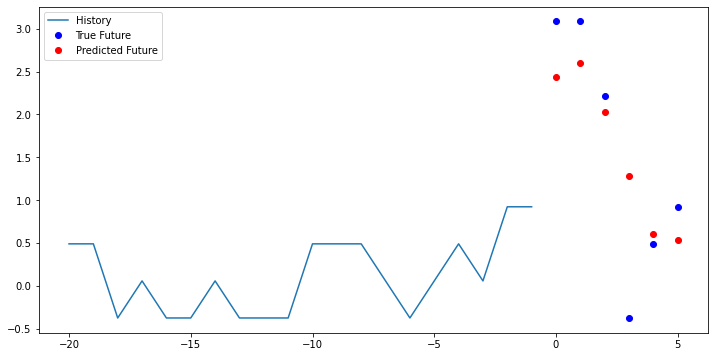

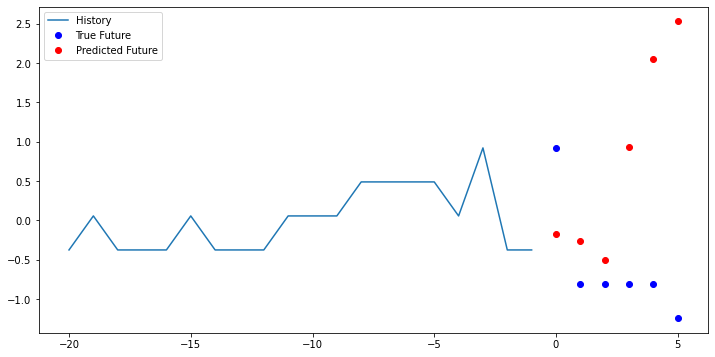

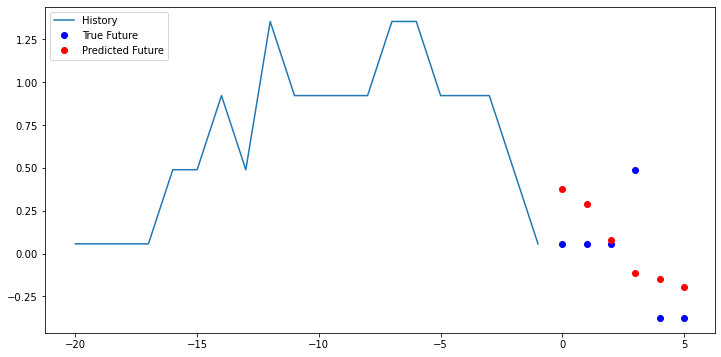

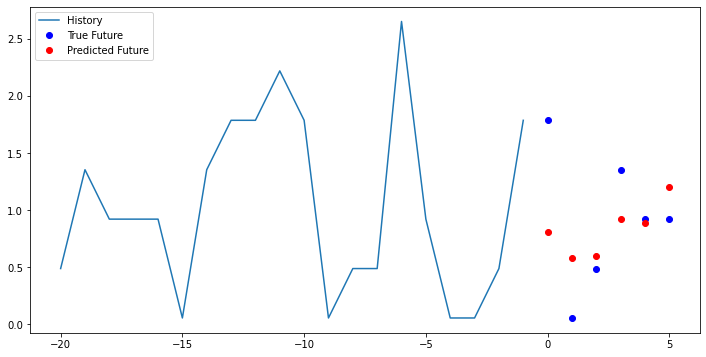

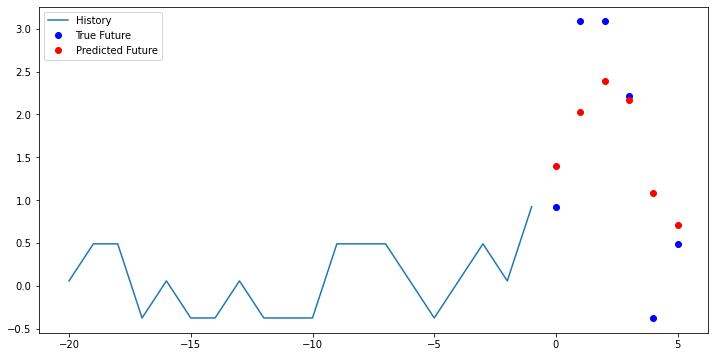

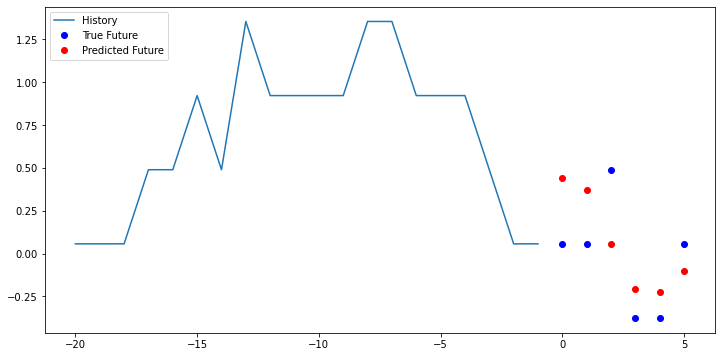

In [72]:
for i in df.sort_values(by=['Turbine_vibration_2X'], ascending=False)[:int(len(df.Turbine_vibration_2X)*0.05)].index[:10]:
    x_test_single, y_test_single = multivariate_data(dataset, dataset[:, 1],
                                               i-100, i + future_target + 1, past_history,
                                               future_target, STEP)
    
    test_data_single = tf.data.Dataset.from_tensor_slices((x_test_single, y_test_single))
    test_data_single = test_data_single.batch(BATCH_SIZE).repeat()
    
    for x, y in test_data_single.take(1):
        multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])